In [1]:
using Crystalline, MPBUtils, JLD2, LinearAlgebra, StaticArrays, SymmetryBases, PyPlot, DelimitedFiles, PrettyTables, Brillouin
using PyCall
np = pyimport("numpy")
include("plotting_utilities.jl") # Julia file for plotting unit cells in an aesthetically pleasing way
cm = 1/2.54;
include("symeigs/wyckoffs_dict.jl");

In [2]:
ph_candidates = [1090, 355, 73, 1194, 493, 1074, 20, 1457, 257, 3062, 91];
# ph_candidates from Figure 1 for convenience

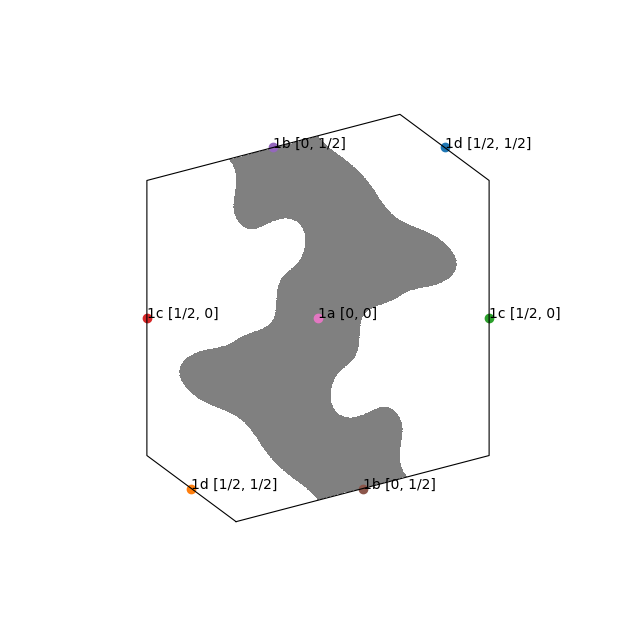

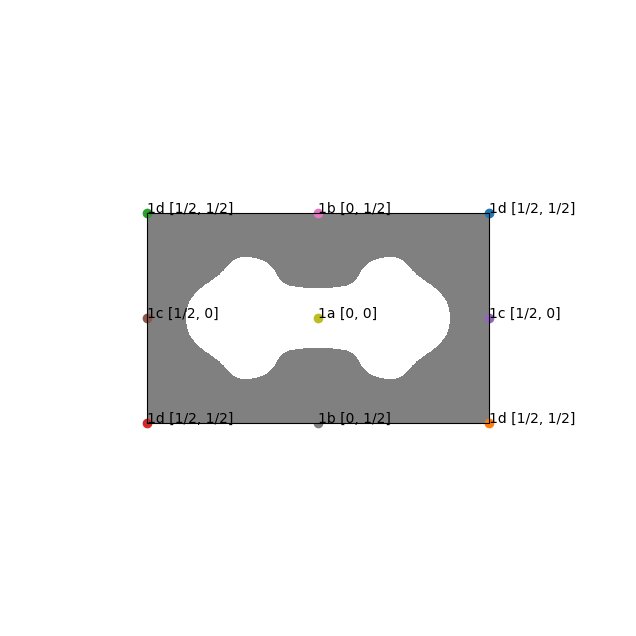

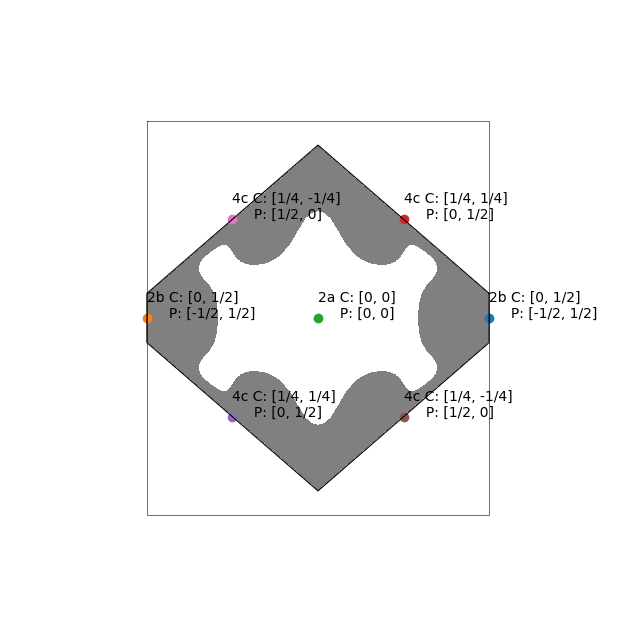

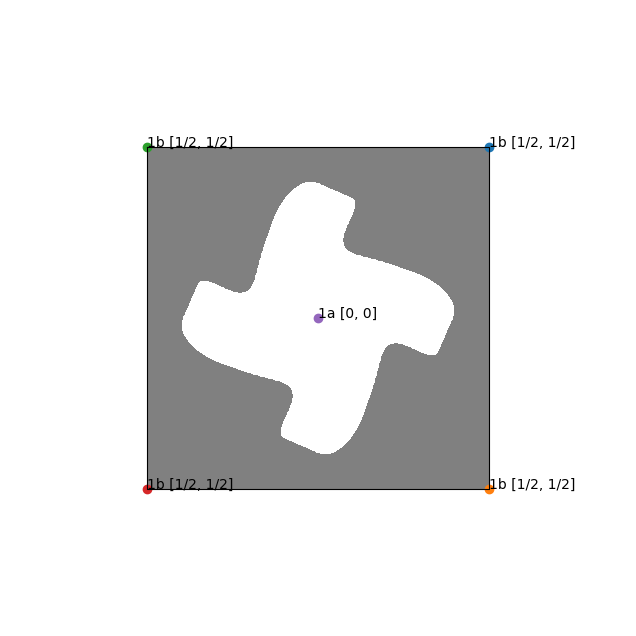

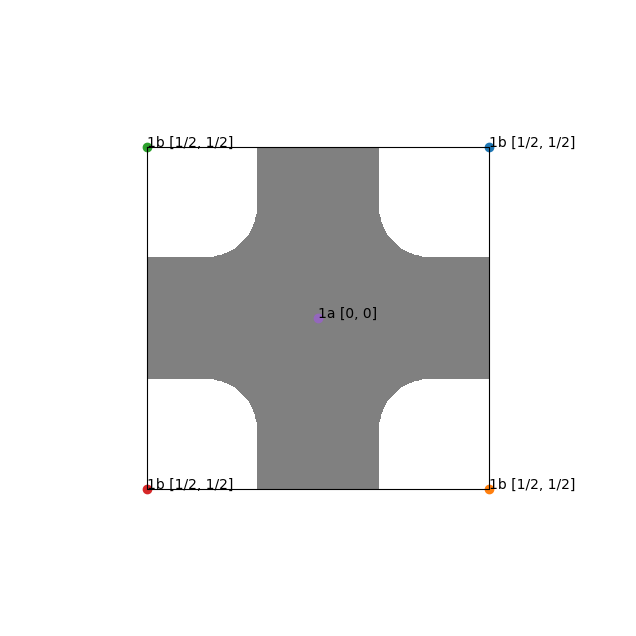

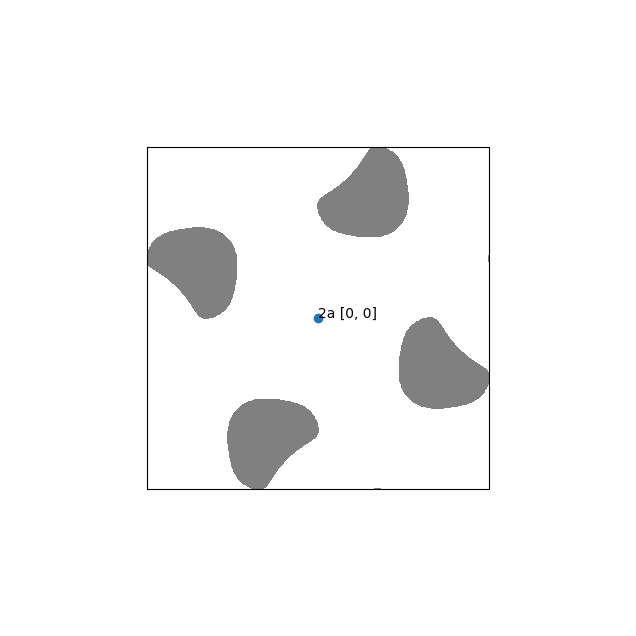

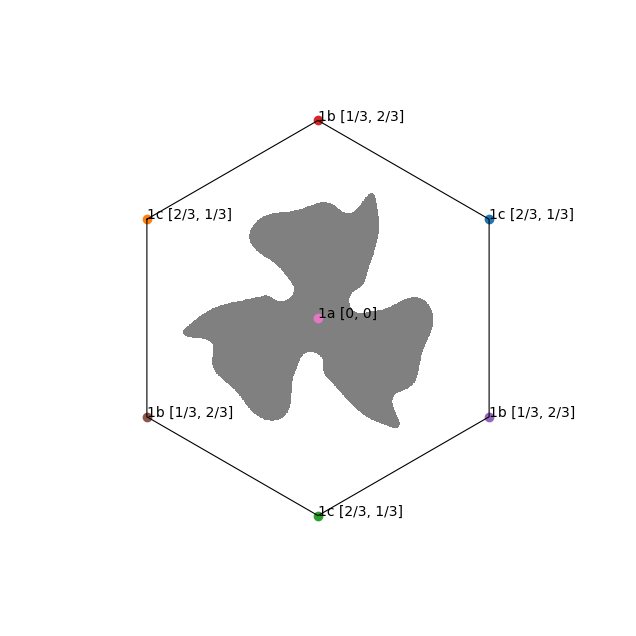

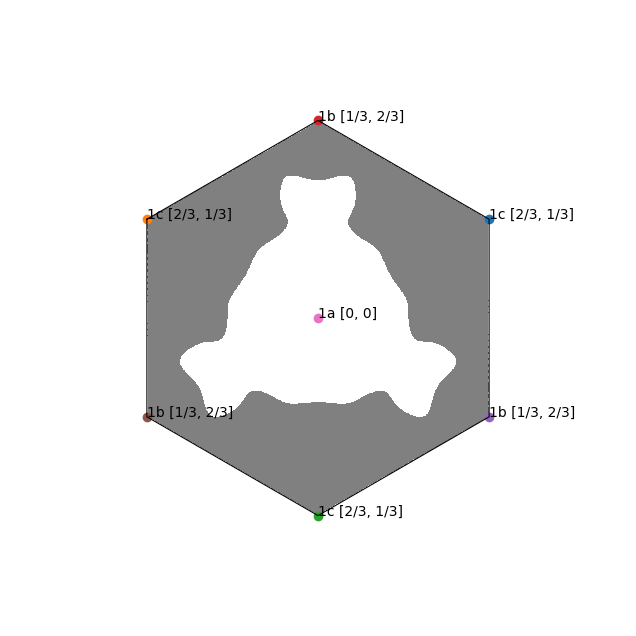

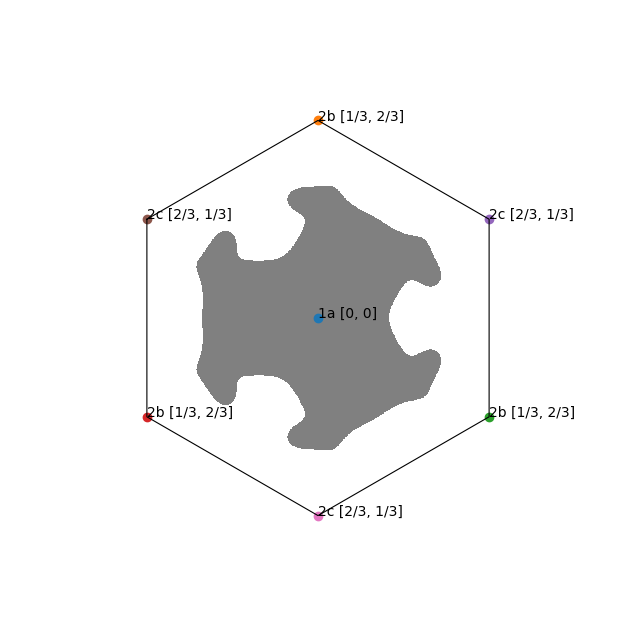

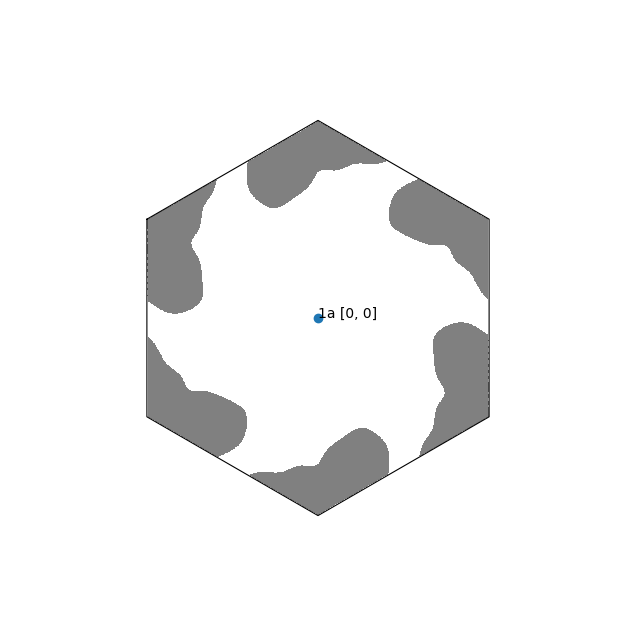

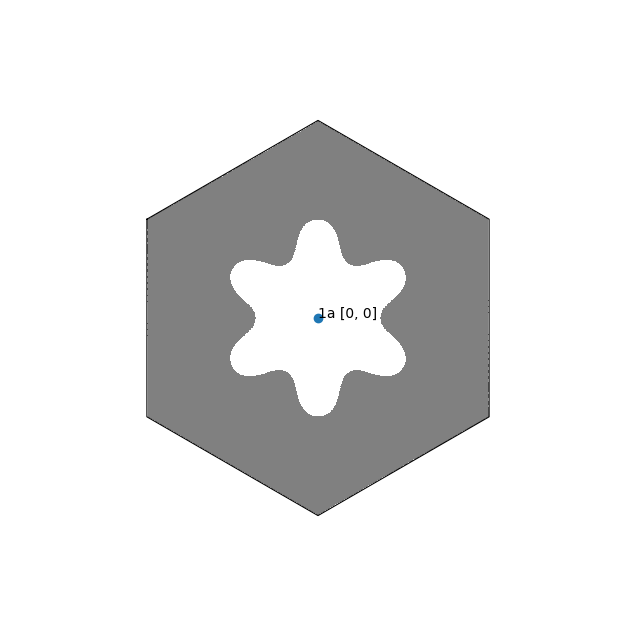

Centering: p
Centering: p
Centering: c
Centering: p
Centering: p
Centering: p
Centering: p
Centering: p
Centering: p
Centering: p
Centering: p


In [61]:
boundaries = 0.9
dir = "./Fig1_Lattice_Pdfs/"
for (i, (id, sg)) in enumerate(zip(ph_candidates, [2, 6, 9:17...]))
    fig = figure(figsize=(8, 8))
    calcname = "./symeigs/input/dim2-sg$(sg)-$id-res64-tm.sh"
    p_or_c = centering(sg, 2)
    println("Centering: ", p_or_c)
    
    Rs, flat, isoval, _ = lattice_from_mpbparams(calcname)
    Rs_conventional = conventionalize(Rs, p_or_c)

    wigner_cell = wignerseitz(Rs) # wigner seitz cell for primitive lattice

    wigner_plot(flat, Rs, wigner_cell; isoval=isoval, fig=fig, ax=gca(), xyz=range(-1, 1, length=1000), in_polygon=true)
    
    if p_or_c == 'c' # if not 'p', then draw conventional unit cell
        wigner_cell_conventional = wignerseitz(Rs_conventional) # conventionalize unit cell (only important for sg 9)
        Brillouin.cartesianize!(wigner_cell_conventional)
        cxs, cys = getindex.(wigner_cell_conventional[1], 1), getindex.(wigner_cell_conventional[1], 2)
        push!(cxs, cxs[1]); push!(cys, cys[1]) # To make a closed loop for the wigner-seitz cell
        gca().plot(cxs, cys, color="black", linewidth=0.4) # plot unit cell
    end
    
    polygon = shapely_polygon(Brillouin.cartesianize(wigner_cell)[1]*1.01) # 1.01 for a bit of tolerance 

    for wp in sg_wyckoffs_dict[sg]
        for x in -2:2
            for y in -2:2
                
                v = wp.v # Wyckoff coordinate in conventional basis
                v_primitivized = primitivize(v, p_or_c) # Wyckoff coordinate in primitive basis (needed since 
                                                        # Rs are in primitive basis)
                v_cartesianized = Brillouin.cartesianize(v_primitivized.cnst-[x, y], Rs)
                polygon.contains(shapely_point(v_cartesianized)) || continue 
                # Wyckoff coordinate in cartesian coordinates 
                wp_name = string(wp.mult, wp.letter)
                scatter(v_cartesianized[1], v_cartesianized[2])
                p_or_c == 'p' ? annotate(wp_name * " " * string(v_primitivized), (v_cartesianized[1], v_cartesianized[2])) : annotate(
                    wp_name * " C: " * string(v) * "\n     P: " * string(v_primitivized) , (v_cartesianized[1], v_cartesianized[2]))
           end
        end
    end
    xlim(-boundaries, boundaries)
    ylim(-boundaries, boundaries)
    gca().set_aspect("equal")
    #savefig(dir*"Sg$(sg)-example_wyckoff.pdf")
end

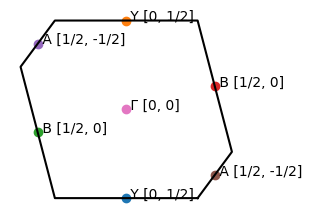

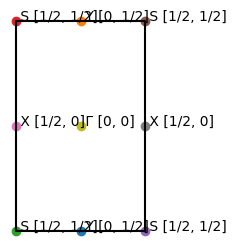

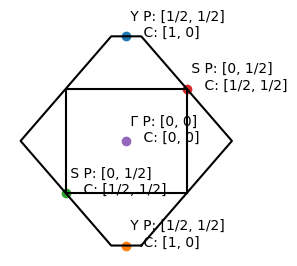

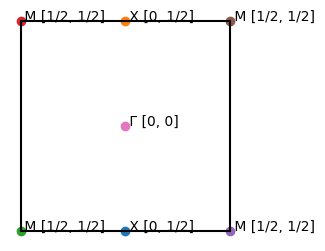

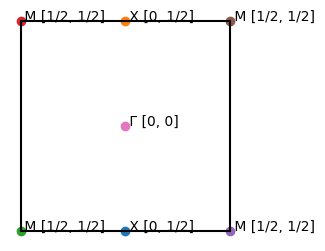

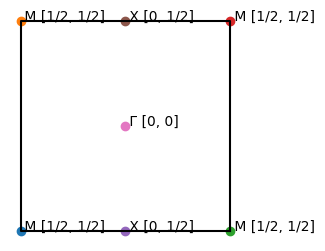

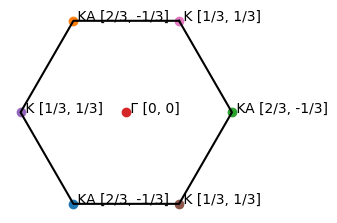

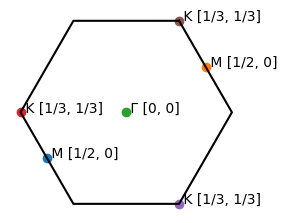

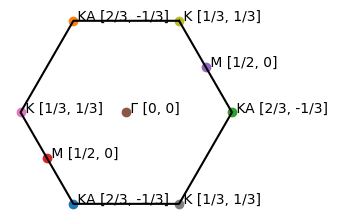

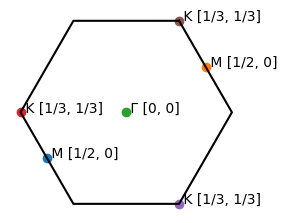

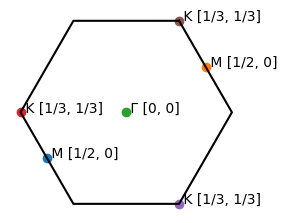

Centering: p
Centering: p
Centering: c
Centering: p
Centering: p
Centering: p
Centering: p
Centering: p
Centering: p
Centering: p
Centering: p


In [23]:
boundaries = 6
dir = "./Fig1_Lattice_Pdfs/"
for (i, (id, sg)) in enumerate(zip(ph_candidates, [2, 6, 9:17...]))
    
    fig = figure(figsize=(3, 3))
    calcname = "./symeigs/input/dim2-sg$(sg)-$id-res64-tm.sh"
    p_or_c = centering(sg, 2)
    println("Centering: ", p_or_c)
    
    Rs, flat, isoval, _ = lattice_from_mpbparams(calcname) # primitive basis
    Rs_conventional = conventionalize(Rs, p_or_c) # conventional basis
    
    Gs = reciprocalbasis(Rs) # primitive basis
    Gs_conventional = reciprocalbasis(Rs_conventional) # conventional basis

    xs = Float64[]
    ys = Float64[]

    verts = wignerseitz(Gs).verts;
    for vert in [verts[1:end]..., verts[1]]
        x, y = Brillouin.cartesianize(vert, Gs)
        push!(xs, x)
        push!(ys, y)
    end
    plot(xs, ys, color="black")
    polygon = shapely_polygon(collect(zip(xs*1.001, ys*1.001)))
    
    kvs = bandreps(sg, 2).kvs
    klabs = bandreps(sg, 2).klabs
    
    for (kv, klab) in zip(kvs, klabs)
        kv_primitivized = primitivize(kv, p_or_c)
        for x_idx in -3:3
            for y_idx in -3:3
                x, y = Brillouin.cartesianize([kv_primitivized.cnst[1]+x_idx, kv_primitivized.cnst[2]+y_idx], Gs)
                polygon.contains(shapely_point(x, y)) || continue 
                scatter(x, y)
                if p_or_c == 'p'
                    annotate(" " * klab * " " * string(kv_primitivized), (x, y))
                else 
                    annotate(" " * klab * " P: " * string(kv_primitivized) * " \n    C: " * string(kv), (x, y))
                end
            end
        end
    end

    if p_or_c == 'c'
        xs = Float64[]
        ys = Float64[]

        verts = wignerseitz(Gs_conventional).verts;
        for vert in [verts[1:end]..., verts[1]]
            x, y = Brillouin.cartesianize(vert, Gs_conventional)
            push!(xs, x)
            push!(ys, y)
        end
        plot(xs, ys, color="black")
    end
    
    gca().set_aspect("equal")
    gca().axis("off")
    #savefig(dir*"Sg$(sg)-example_highsymmetryks.pdf")
end